# **Attacking Image Classifiers with FoolBox**

* CS486: Robust Machine Learning 
* Drexel University - Spring 2023 
* Luke Ingram


In [2]:
import os 
import pickle
from typing import Dict, Any

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torchvision import transforms as vt
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

import foolbox 

from pytorch_cifar.models import VGG, MobileNetV2, ResNet18

from AdversarialDataset import AdversarialDataset


## **Loading Trained Models & Data**

In [4]:
MODEL_SAVES_DIR = os.path.join('models', 'checkpoints', 'classifiers')
DEVICE = torch.device('cuda')
BATCH_SIZE = 1

In [5]:
# Load classifiers we trained on CIFAR-10 last section
vgg16 = VGG('VGG16', num_classes=10)
vgg16.load_state_dict(torch.load(os.path.join(MODEL_SAVES_DIR, 'vgg16.pth')))
vgg16 = vgg16.to(DEVICE)
vgg16.eval()

mobilenet = MobileNetV2(num_classes=10)
mobilenet.load_state_dict(torch.load(os.path.join(MODEL_SAVES_DIR, 'mobilenetv2.pth')))
mobilenet = mobilenet.to(DEVICE)
mobilenet.eval()

resnet = ResNet18(num_classes=10)
resnet.load_state_dict(torch.load(os.path.join(MODEL_SAVES_DIR, 'resnet18.pth')))
resnet = resnet.to(DEVICE)
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

Now we load our testing set:

In [6]:
# Load CIFAR-10
mean, std = [-0.0541, -0.0127,  0.0265], [0.9868, 1.0000, 1.0029]

transforms = vt.Compose([
    vt.ToTensor(),
    vt.Normalize(mean, std)
])

cifar10_dataset = CIFAR10(root='./data', train=False, download=True, transform=transforms)
cifar10_loader = DataLoader(cifar10_dataset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified


We saw the performance of our classifiers on the testing set in the last section, but to reiterate:

In [7]:
# Compare Models on testing dataset
def test(model, loader, device):
    model.eval()

    correct = 0
    total = 0 

    with torch.no_grad(): 
         for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Get predictions and update counts
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Compute accuracy
    accuracy = 100 * correct / total
    return accuracy



In [ ]:
print(f"VGG16 Test Accuracy: {test(vgg16, cifar10_loader, DEVICE)}")
print(f'MobileNetV2 Test Accuracy: {test(mobilenet, cifar10_loader, DEVICE)}')
print(f'ResNet18 Testing Accuracy: {test(resnet, cifar10_loader, DEVICE)}')

In [7]:
# Load Labels
labelType = b'label_names'

meta_file = os.path.join("data", "cifar-10-batches-py", "batches.meta")

with open(meta_file, 'rb') as f:
    meta_data = pickle.load(f, encoding='bytes')
    # Extract label names
    label_names = [label.decode('utf-8') for label in meta_data[labelType]]
    f.close()

print(*label_names[:11], '...', sep=', ')

airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck, ...


## **Attacking the Classifiers**

In [8]:
DATA_SAVE_ROOT = os.path.join("data", "adversarial")

Before we begin our white-box attacks we define the general attack procedure

In [9]:
# This expects batch size of 1
def generate_adv_imgs(
        model: nn.Module, 
        attack: foolbox.attacks.Attack, 
        loader: DataLoader, 
        save_path: str,
        attack_kwargs = Dict[str, Any] 
    ) -> None: 

    fmodel = foolbox.models.PyTorchModel(model, bounds=(-0.27, 1.07), device=DEVICE)

    adv_imgs, adv_idx, adv_label = [], [], []

    for idx, (imgs, labels) in tqdm(enumerate(loader)): 

        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        _, adv_sample, success = attack(fmodel, imgs, labels, **attack_kwargs)
      
        if not success: 
            continue

        adv_imgs.append(adv_sample[0].cpu().squeeze(0))
        adv_idx.append(idx)
        adv_label.append(labels.cpu())
    
    print(f"saving adv data to {os.path.join(DATA_SAVE_ROOT, save_path)}")
    with open(os.path.join(DATA_SAVE_ROOT, save_path, 'idx.pickle'), 'wb') as fp: 
        pickle.dump(adv_idx, fp)
    
    with open(os.path.join(DATA_SAVE_ROOT, save_path, 'imgs.pickle'), 'wb') as fp: 
        pickle.dump(adv_imgs, fp)

    with open(os.path.join(DATA_SAVE_ROOT, save_path, 'labels.pickle'), 'wb') as fp: 
        pickle.dump(adv_label, fp)
    fp.close()
        

### **FGSM**

We generate three datasets of adversarial images one designed for each classifier. (The other attacks will follow a similar structure)

In [10]:
# VGG16
generate_adv_imgs(
    model=vgg16,
    attack=foolbox.attacks.FGSM(), 
    loader=cifar10_loader,
    save_path=os.path.join('vgg16', 'fgsm'),
    attack_kwargs={'epsilons': [0.01]}
    )


# MobileNetV2 
generate_adv_imgs(
    model=mobilenet,
    attack=foolbox.attacks.FGSM(), 
    loader=cifar10_loader, 
    save_path=os.path.join('mobilenetv2', 'fgsm'), 
    attack_kwargs={'epsilons': [0.01]}
)

# ResNet18
generate_adv_imgs(
    model=resnet, 
    attack=foolbox.attacks.FGSM(),
    loader=cifar10_loader,
    save_path=os.path.join('resnet18', 'fgsm'),
    attack_kwargs={'epsilons': [0.01]}
)

10000it [02:50, 58.61it/s]


saving adv data to data\adversarial\vgg16\fgsm


10000it [06:33, 25.41it/s]


saving adv data to data\adversarial\mobilenetv2\fgsm


10000it [03:18, 50.36it/s]


saving adv data to data\adversarial\resnet18\fgsm


**Visualization:**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


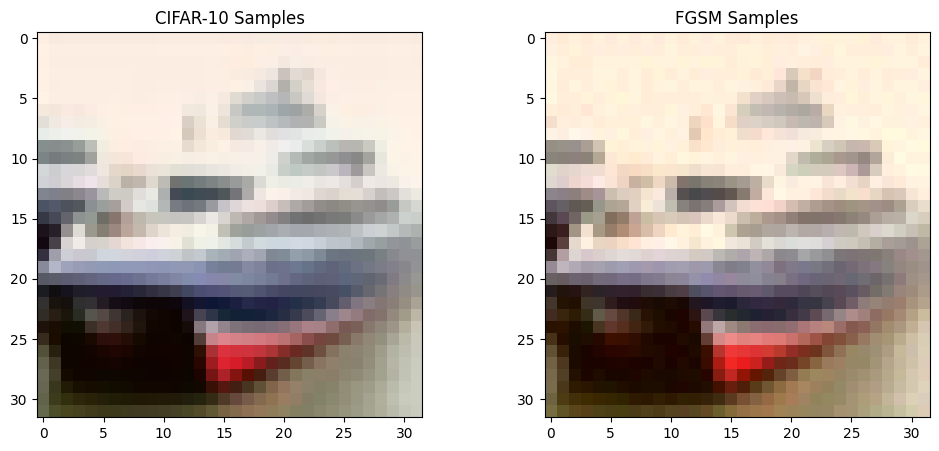

In [14]:
# Get CIFAR-10 sample
cifar10_iter = iter(cifar10_loader)
next(cifar10_iter)
cifar_img, cifar_label = next(iter(cifar10_iter))


adv_transforms = vt.Compose([ 
    vt.Normalize(mean, std)
])

# Using MobileNetV2 as the sample
adv_dataset_mobilenet = AdversarialDataset(os.path.join(DATA_SAVE_ROOT, 'mobilenetv2', 'fgsm'), transform=adv_transforms)
adv_loader_mobilenet = DataLoader(adv_dataset_mobilenet, batch_size=BATCH_SIZE, shuffle=False)

adv_img, adv_label = next(iter(adv_loader_mobilenet))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(np.transpose(make_grid(cifar_img), (1, 2, 0)))
ax1.set_title("CIFAR-10 Samples")
ax2.imshow(np.transpose(make_grid(adv_img.cpu().squeeze(0)), (1, 2, 0)))
ax2.set_title('FGSM Samples')

plt.show()



**Testing Accuracy:**

In [16]:
adv_dataset_vgg = AdversarialDataset(os.path.join(DATA_SAVE_ROOT, 'vgg16', 'fgsm'), transform=adv_transforms)
adv_loader_vgg = DataLoader(adv_dataset_vgg, batch_size=BATCH_SIZE, shuffle=False)

print(f"VGG16 FGSM Accuracy: {test(vgg16, adv_loader_vgg, DEVICE)}")

print(f"MobileNetV2 FGSM Accuracy: {test(mobilenet, adv_loader_mobilenet, DEVICE)}")

adv_dataset_resnet = AdversarialDataset(os.path.join(DATA_SAVE_ROOT, 'resnet18', 'fgsm'), transform=adv_transforms)
adv_loader_resnet = DataLoader(adv_dataset_resnet, batch_size=BATCH_SIZE, shuffle=False)

print(f"ResNet18 FGSM Accuracy: {test(resnet, adv_loader_resnet, DEVICE)}")

VGG16 FGSM Accuracy: 1.9319227230910763
MobileNetV2 FGSM Accuracy: 3.3637928751158785
ResNet18 FGSM Accuracy: 2.5690430314707773


### **$L_\infty$**

In [15]:
# VGG16
generate_adv_imgs(
    model=vgg16,
    attack=foolbox.attacks.LinfPGD(), 
    loader=cifar10_loader,
    save_path=os.path.join('vgg16', 'linfty'),
    attack_kwargs={'epsilons': [0.01]}
    )

# MobileNetV2 
generate_adv_imgs(
    model=mobilenet,
    attack=foolbox.attacks.LinfPGD(), 
    loader=cifar10_loader, 
    save_path=os.path.join('mobilenetv2', 'linfty'), 
    attack_kwargs={'epsilons': [0.01]}
)

# ResNet18
generate_adv_imgs(
    model=resnet, 
    attack=foolbox.attacks.LinfPGD(),
    loader=cifar10_loader,
    save_path=os.path.join('resnet18', 'linfty'),
    attack_kwargs={'epsilons': [0.01]}
)

0it [00:00, ?it/s]

3it [00:00,  3.06it/s]


KeyboardInterrupt: 

**Visualization:**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


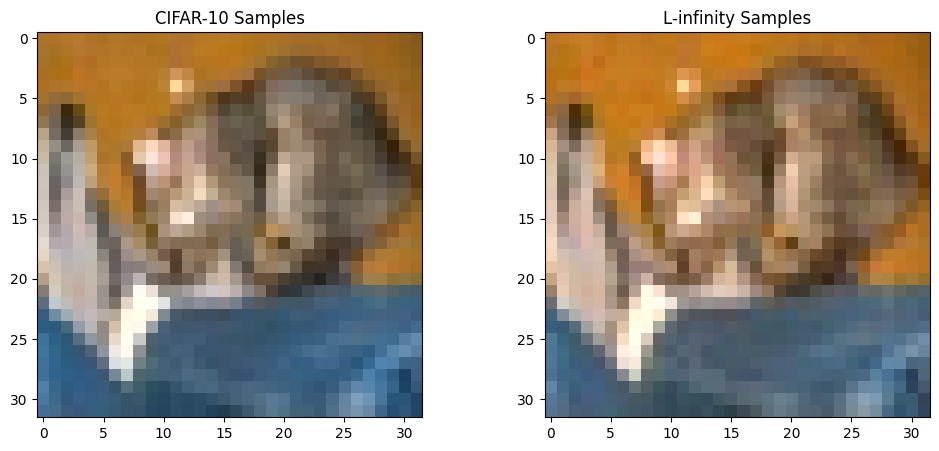

In [14]:
# Using MobileNetV2 as the sample
adv_dataset_mobilenet = AdversarialDataset(os.path.join(DATA_SAVE_ROOT, 'mobilenetv2', 'linfty'), transform=adv_transforms)
adv_loader_mobilenet = DataLoader(adv_dataset_mobilenet, batch_size=BATCH_SIZE, shuffle=False)

adv_img, adv_label = next(iter(adv_loader_mobilenet))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(np.transpose(make_grid(cifar_img), (1, 2, 0)))
ax1.set_title("CIFAR-10 Samples")
ax2.imshow(np.transpose(make_grid(adv_img.cpu().squeeze(0)), (1, 2, 0)))
ax2.set_title('L-infinity Samples')

plt.show()


**Testing Accuracy:**

In [18]:
adv_dataset_vgg = AdversarialDataset(os.path.join(DATA_SAVE_ROOT, 'vgg16', 'linfty'), transform=adv_transforms)
adv_loader_vgg = DataLoader(adv_dataset_vgg, batch_size=BATCH_SIZE, shuffle=False)

print(f"VGG16 FGSM Accuracy: {test(vgg16, adv_loader_vgg, DEVICE)}")

print(f"MobileNetV2 FGSM Accuracy: {test(mobilenet, adv_loader_mobilenet, DEVICE)}")

adv_dataset_resnet = AdversarialDataset(os.path.join(DATA_SAVE_ROOT, 'resnet18', 'linfty'), transform=adv_transforms)
adv_loader_resnet = DataLoader(adv_dataset_resnet, batch_size=BATCH_SIZE, shuffle=False)

print(f"ResNet18 FGSM Accuracy: {test(resnet, adv_loader_resnet, DEVICE)}")

VGG16 FGSM Accuracy: 2.1817676486937185
MobileNetV2 FGSM Accuracy: 0.5423865006026517
ResNet18 FGSM Accuracy: 1.1178388448998602
